# Multi-Modal RAG Hands-On Solutions

In those exercises two different PDFs will be provided to the RAG pipeline: `Explainable_machine_learning_prediction_of_edema_a.pdf` and `Modeling tumor size dynamics based on real‐world electronic health records.pdf`.


## Setup

In [ ]:
import sys
sys.path.append("../../")

0

In [ ]:
!pip install -r ../../requirements.txt

In [2]:
import os
import getpass
import json
from tqdm import tqdm

import numpy as np

from helpers.data_processing import SimpleChunker, PDFExtractor
from helpers.embedding import (
    OpenAITextEmbeddings,
    ImageEmbeddings,
    ImageEmbeddingsForText,
)
from helpers.vectorstore import (
    ChromaDBVectorStore,
    VectorStoreRetriever,
)
from helpers.constants_and_data_classes import Roles
from helpers.llm import OpenAILLM
from helpers.rag import Generator, DefaultRAG

In [3]:
data_folder = "../../data"

pdf_files = [
    "Explainable_machine_learning_prediction_of_edema_a.pdf",
    "Modeling tumor size dynamics based on real‐world electronic health records.pdf",
]

text_vector_store_collection = "text_collection"
image_vector_store_collection = "image_collection"

text_vector_store_full_collection = "text_collection_full"
image_vector_store_full_collection = "image_collection_full"

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

## Define the RAG pipeline

In [5]:
data_extractor = PDFExtractor()
chunker = SimpleChunker(max_chunk_size=1000)


text_chunks = []
image_chunks = []

for pdf_file in pdf_files:
    pdf_path = os.path.join(data_folder, pdf_file)
    _, text, images = data_extractor.extract_text_and_images(pdf_path)
    text_chunks_curr = chunker.chunk_text(text, {"source_text": pdf_file})
    image_chunks_curr = chunker.chunk_images(images, {"source_text": pdf_file})
    text_chunks.extend(text_chunks_curr)
    image_chunks.extend(image_chunks_curr)

In [6]:
text_embedding_model = OpenAITextEmbeddings()
text_embeddings = text_embedding_model.get_embedding(
    [chunk.content for chunk in text_chunks]
)

In [7]:
image_embeddings = []

image_embedding_model = ImageEmbeddings()
for chunk in tqdm(image_chunks):
    image_embeddings.append(image_embedding_model.get_embedding(chunk.content))

image_embeddings = np.array(image_embeddings)

image_text_embedding_model = ImageEmbeddingsForText()

100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


In [8]:
vector_store_text = ChromaDBVectorStore(text_vector_store_full_collection)
vector_store_text.insert_chunks(text_chunks, text_embeddings)

vector_store_image = ChromaDBVectorStore(image_vector_store_full_collection)
vector_store_image.insert_chunks(image_chunks, image_embeddings)

In [9]:
retriever = VectorStoreRetriever(
    text_embedding_model,
    vector_store_text,
    image_text_embedding_model,
    vector_store_image,
)

In [10]:
llm = OpenAILLM(temperature=0.3)

OpenAI LLM loaded: gpt-4o-mini; temperature: 0.3; seed: 42


In [11]:
system_prompt = """You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer."""
print(system_prompt)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.


In [12]:
rag_template = """
Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:
"""
print(rag_template)


Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:



In [13]:
generator = Generator(llm, system_prompt, rag_template)

In [14]:
rag_without_images = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    generator=generator,
    params={"top_k_text": 5},
)

In [15]:
rag = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    image_text_embedding_model=image_text_embedding_model,
    image_vector_store=vector_store_image,
    generator=generator,
    params={"top_k_text": 5, "top_k_image": 3},
)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
<span id="page-11-1"></span>Additional supporting information can be found online in the Supporting Information section at the end of this article. **How to cite this article:** Amato F, Strotmann R, Castello R, et al. Explainable machine learning prediction of edema adverse events in patients treated with tepotinib. *Clin Transl Sci*. 2024;17:e70010. doi[:10.1111/cts.70010](https://doi.org/10.1111/cts.70010)

Chunk 2: 
DOI: [10.1111/cts.70010](https://doi.org/10.1111/cts.70010) ### **ARTICLE

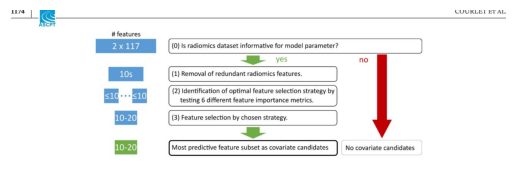

Annex: Image from chunk 7


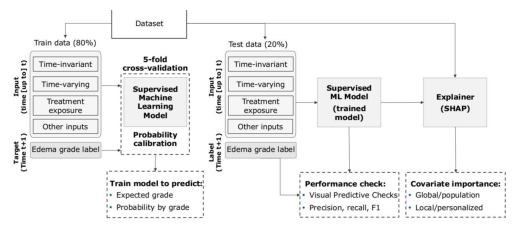

Annex: Image from chunk 8


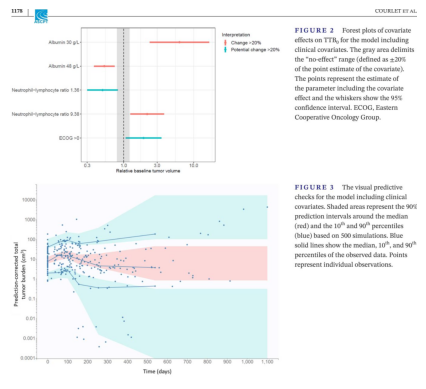

Total input tokens: 83566
Total output tokens: 190
Total tokens: 83756
Estimated cost: $0.0126


In [16]:
answer, sources, cost = rag.execute(
    "Here goes my amazing question!",
    {},
    verbose=True,
)

In [17]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "The images from chunks 6, 7, and 8 illustrate various aspects of a machine learning model used to predict edema in patients treated with tepotinib. Chunk 6 shows a flowchart for feature selection in a radiomics dataset, indicating steps to determine if the dataset is informative and how to select predictive features. Chunk 7 presents a diagram of the model training process, including data division, input types, and performance checks. Chunk 8 provides visual representations of covariate effects and predictive checks, highlighting the importance of certain clinical covariates in the model's predictions.",
   "chunk_used": [
      6,
      7,
      8
   ],
   "answer": "The images depict the process of feature selection and model training for predicting edema in patients, emphasizing the role of various clinical covariates and the methodology for validating the model's performance."
}


In [18]:
# The chunks retrieved by the retriever:
print(len(sources))
print(sources[0])

8
{'chunk_id': '61', 'chunk': Chunk(chunk_id=61, content='<span id="page-11-1"></span>Additional supporting information can be found online in the Supporting Information section at the end of this article. **How to cite this article:** Amato F, Strotmann R, Castello R, et al. Explainable machine learning prediction of edema adverse events in patients treated with tepotinib. *Clin Transl Sci*. 2024;17:e70010. doi[:10.1111/cts.70010](https://doi.org/10.1111/cts.70010)', metadata={'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 61}, data_type=<DataType.TEXT: 'text'>, score=None), 'fused_score': 0.016129032258064516, 'average_original_score': 1.6859585046768188}


In [19]:
print(cost)

0.0126489


# Hands-on Exercises

1. Explore the code
2. Test questions and evaluate answers
3. Discuss possible improvements
4. (Optional - Advanced) Implemented query expansion

## 1. Explore the code

Quickly go through the code and the notebooks to ensure you understand how each block works.

No solution provided for this exercise.

## 2. Test questions and evaluate answers

The second exercise consist of testing questions and evaluating the answers. To do so, use the `rag` and `rag_without_images` pipelines defined previously and use them as shown above.

### 2.1 Question about text (1/2)

Ask a question about `Explainable_machine_learning_prediction_of_edema_a.pdf` that can be answered with text. Use `rag_without_images`. 

Check the answer and verify that the chunks used belong to he correct document.

If you don't have any idea, you can ask "How did cumulative tepotinib dose impact edema predictions, and what insights did SHAP provide about this relationship?".

In [20]:
answer, sources, cost = rag_without_images.execute(
    "How did cumulative tepotinib dose impact edema predictions, and what insights did SHAP provide about this relationship?",
    {},
    verbose=True,
)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
The second objective of the study was the identification of the factors predicting edema occurrence and evolution over time. The Shapley Additive exPlanations (SHAP) method was used to investigate the role different factors have toward a specific estimation of edema occurrence obtained via the best predictive model, both at population and patient level. The use of this approach overcomes the lack of explainability of ML models, which approximate complex nonlinear functions from data in a not 

In [21]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To answer the question, I analyzed the relevant chunks. From Chunk 4, it is noted that patients with higher cumulative doses of tepotinib had a lower probability of experiencing edema of grade 2+. This suggests that longer treatment duration without severe adverse effects correlates with higher cumulative doses. Additionally, Chunk 1 and Chunk 5 highlight that SHAP analysis was used to identify important covariates, including cumulative dose, in predicting edema. The SHAP method provided insights into how different factors, including cumulative dose and serum albumin levels, influenced the predicted probabilities of edema occurrence. Overall, the cumulative dose appears to have a protective effect against severe edema, as indicated by the SHAP analysis.",
   "chunk_used": [
      4,
      1,
      5
   ],
   "answer": "Higher cumulative doses of tepotinib were associated with a lower probability of experiencing severe edema (grade 2+). SHAP analysis revea

In [22]:
print(len(sources))
for source in sources:
    print(source["chunk"].metadata)

5
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 11}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 44}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 4}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 43}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 2}


### 2.2 Question about text (2/2)

Ask a question about `Modeling tumor size dynamics based on real‐world electronic health records.pdf` that can be answered with text. Use `rag_without_images`. 

Check the answer and verify that the chunks used belong to this document.

If you don't have any idea, you can use "What was the rationale for using an ON/OFF treatment effect model instead of a dose-dependent model?".

In [23]:
answer, sources, cost = rag_without_images.execute(
    "What was the rationale for using an ON/OFF treatment effect model instead of a dose-dependent model?",
    {},
    verbose=True,
)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
The paucity of baseline images prevented us to estimate the growth rate constant that was fixed to a literature value obtained from a population similar to our cohort[.4](#page-10-3) Sensitivity analyses provided confidence regarding the suitability of the value for our analysis. Our data supported an ON/OFF treatment effect, with better model performances as compared to a model with a treatment effect linearly dependent on the doses. This is in line with literature evidence indicating that, 

In [24]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "The rationale for using an ON/OFF treatment effect model instead of a dose-dependent model is based on the observed performance of the models during analysis. Specifically, the ON/OFF treatment effect model demonstrated a significantly lower objective function value (OFV) compared to the dose-dependent model, indicating better fit and predictive accuracy. This finding aligns with literature suggesting that, within the dose ranges used in clinical practice, the exposure-response relationship of immune checkpoint inhibitors (ICIs) tends to plateau, meaning that increasing doses do not necessarily lead to increased treatment effects. Additionally, the ON/OFF model provided a clearer representation of treatment dynamics, which is crucial for understanding the effects of treatment discontinuation and subsequent therapy initiation. These insights were derived from the comparisons made in Chunk 3 and Chunk 2.",
   "chunk_used": [
      2,
      3
   ],
   "answe

In [25]:
print(len(sources))
for source in sources:
    print(source["chunk"].metadata)

5
{'source_text': 'Modeling tumor size dynamics based on real‐world electronic health records.pdf', 'document_chunk_id': 41}
{'source_text': 'Modeling tumor size dynamics based on real‐world electronic health records.pdf', 'document_chunk_id': 19}
{'source_text': 'Modeling tumor size dynamics based on real‐world electronic health records.pdf', 'document_chunk_id': 27}
{'source_text': 'Modeling tumor size dynamics based on real‐world electronic health records.pdf', 'document_chunk_id': 18}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 43}


### 2.3 Question about a plot

Find a question about a plot in one of the two documents that can not be answered using the text. 

First, ask the question to the only-text RAG pipeline (`rag_without_images`) and verify it can not answer it.

Second, ask it to the multi-modal RAG pipeline (`rag`) and check the answer. Verify that the chunks used belong to this document.

If you don't know which question to ask, you can try: "What is the lowest SHAP value observed for 'weight' on probability of severe edema?"

In [26]:
answer, sources, cost = rag_without_images.execute(
    "What is the lowest SHAP value observed for 'weight' on probability of severe edema?",
    {},
    verbose=True,
)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP va

In [27]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "The question asks for the lowest SHAP value observed for 'weight' on the probability of severe edema. However, none of the provided chunks explicitly mention 'weight' or its corresponding SHAP values. The chunks discuss the influence of age, albumin levels, and cumulated dose on edema predictions but do not provide specific information about the SHAP values related to 'weight'. Therefore, I cannot provide an answer based on the available information.",
   "chunk_used": [],
   "answer": "The provided chunks do not contain information regarding the SHAP value for 'weight' on the probability of severe edema."
}


You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP va

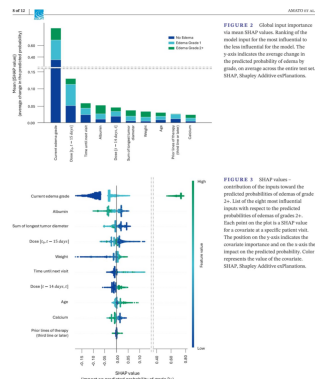

Annex: Image from chunk 7


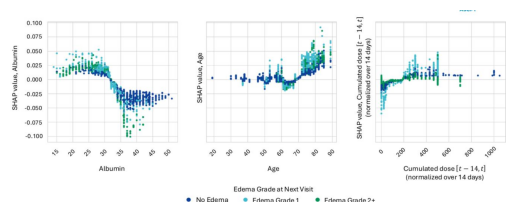

Annex: Image from chunk 8


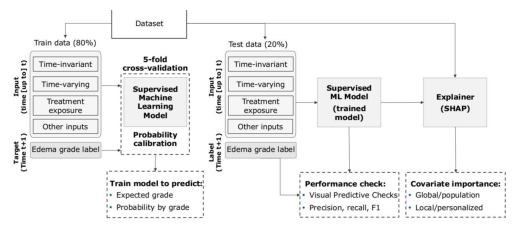

Total input tokens: 100504
Total output tokens: 132
Total tokens: 100636
Estimated cost: $0.0152


In [28]:
answer, sources, cost = rag.execute(
    "What is the lowest SHAP value observed for 'weight' on probability of severe edema?",
    {},
    verbose=True,
)

In [29]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To determine the lowest SHAP value observed for 'weight' on the probability of severe edema, I analyzed the provided images. In Figure 3 from chunk 6, the SHAP values for 'weight' are plotted, showing a range of values. The lowest SHAP value for 'weight' appears to be around -0.1, indicating a negative contribution to the probability of severe edema.",
   "chunk_used": [
      6
   ],
   "answer": "The lowest SHAP value observed for 'weight' on the probability of severe edema is approximately -0.1."
}


In [30]:
print(len(sources))
for source in sources:
    print(source["chunk"].metadata)

8
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 39}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 38}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 37}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 42}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 29}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 2}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 3}
{'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'document_chunk_id': 1}


## 3. Discuss possible improvements

Discuss how the pipeline could be improved to achieve better answers and identify the current pain-points. How will it be different if using a different architecture of multi-modal RAG? 

If time permits, try to change some parameters of the pipeline to see how it impacts the result.

Participants can discuss every step of the pipeline (data extraction, embedding models, retrieval improvement, sending more chunks, providing to the LLM part of the metadata (which document does the chunk come from), better prompting, ect.). Regarding the architecture, they can argue that a multi-modal database would be better, as it would not take the N best texts and then the M best images, but the N best documents, whatever they are text or image. 

Then, if they have time, they can try to change the parameters of the pipeline (number of chunks retrieved, temperature, etc.).

## 4. (Optional - Advanced) Implement query expansion

Implement query expansion by defining the prompt for the LLM to generate alternative queries to search more broadly in the vector store.

You should provide a system prompt, explaining to the LLM it's role (it has to find rephrasing of the query).

And you should write a template for the query, stating it to provide the alternative queries based on the user query. In the template you can provide `{query}` to give it the user query and `{expansion_number}` for the number of alternative queries.

The LLM should write each query on a new line.

Try the results of one of the previous question, how does it impact the performance? And how does it impact the cost?

In [31]:
query_expansion_system_message = {
    "role": "system",
    "content": "You are a focused assistant designed to generate multiple, relevant search queries based solely on a single input query. Your task is to produce a list of these queries in English, without adding any further explanations or information.",
}

query_expansion_template_query = """
        Generate multiple search queries related to: {query}, and translate them in english if they are not already in english. Only output {expansion_number} queries in english.
        OUTPUT ({expansion_number} queries):
    """

In [32]:
rag_with_query_expansion = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    image_text_embedding_model=image_text_embedding_model,
    image_vector_store=vector_store_image,
    generator=generator,
    params={"top_k_text": 5, "top_k_image": 1, "number_query_expansion": 3},
    query_expansion_developer_message=query_expansion_system_message,
    query_expansion_template_query=query_expansion_template_query,
)

Total input tokens: 108
Total output tokens: 56
Total tokens: 164
Estimated cost: $0.0000
Query expansion cost: 0.0000
Expanded queries:
1. What is the minimum SHAP value for 'weight' affecting severe edema probability?
2. How does the SHAP value for 'weight' correlate with severe edema risk?
3. What are the implications of low SHAP values for 'weight' in predicting severe edema?

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. w

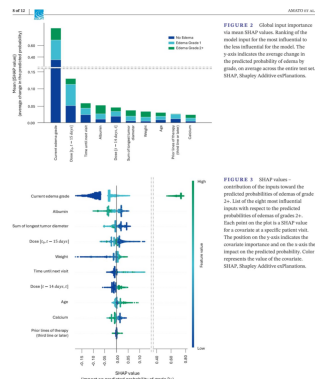

Total input tokens: 26957
Total output tokens: 158
Total tokens: 27115
Estimated cost: $0.0041


In [33]:
answer, sources, cost = rag_with_query_expansion.execute(
    "What is the lowest SHAP value observed for 'weight' on probability of severe edema?",
    {},
    verbose=True,
)

In [34]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To determine the lowest SHAP value observed for 'weight' on the probability of severe edema, I reviewed the provided chunks, particularly focusing on the figures and descriptions related to SHAP values. In Figure 3, which illustrates the contribution of various inputs toward the predicted probabilities of edemas of grade 2+, the SHAP values for 'weight' are displayed. The lowest SHAP value for 'weight' appears to be around -0.1, indicating a negative impact on the predicted probability of severe edema.",
   "chunk_used": [
      2,
      5
   ],
   "answer": "The lowest SHAP value observed for 'weight' on the probability of severe edema is approximately -0.1."
}


In [35]:
print(cost)

0.00418815


----------------